# Introduction to Deep Learning
## Assignment 3, Part 2

### Generative Models

<img src="https://lilianweng.github.io/lil-log/assets/images/three-generative-models.png" width="500"> 


In this notebook we are going to cover two generative models for generating novel images:

1. Variational Autoencoders (VAEs)
2. Generative adversarial networks (GANs)

Your main goal will be to retrain these models on a dataset of your choice and do some experiments on the learned latent space.


In [ ]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive



### Dataset

This dataset is called [Flickr-Faces-HQ Dataset](https://github.com/NVlabs/ffhq-dataset). Here we will use a downsampled version of it (64x64x3) that will speed up all the experiments.

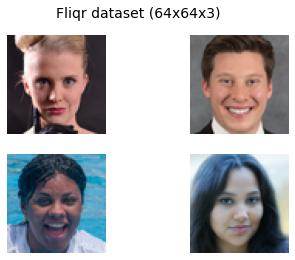

In [ ]:
def load_real_samples(scale=False):
    X = np.load('/content/drive/MyDrive/face_dataset_64x64.npy')[:20000, :, :, :]
    if scale:
        X = (X - 127.5) * 2
    return X / 255.

# We will use this function to display the output of our models throughout this notebook
def grid_plot(images, epoch='', name='', n=3, save=False, scale=False):
    if scale:
        images = (images + 1) / 2.0
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis('off')
        plt.imshow(images[index])
    fig = plt.gcf()
    fig.suptitle(name + '  '+ str(epoch), fontsize=14)
    if save:
        filename = 'results/generated_plot_e%03d_f.png' % (epoch+1)
        plt.savefig(filename)
        plt.close()
    plt.show()


dataset = load_real_samples()
grid_plot(dataset[np.random.randint(0, 1000, 4)], name='Fliqr dataset (64x64x3)', n=2)

## 2.1. Introduction

The generative model that we are going to cover both have the following components:

1. A downsampling architecture (encoder in case of VAE, and discriminator in case of GAN) to either extract features from the data or model its distribution.
2. An upsampling architecture (decoder for VAE, generator for GAN) that will use some kind of latent vector to generate new samples that resemble the data that it was trained on.

Since we are going to be dealing with images, we are going to use convolutional networks for upsampling and downsampling, similar to what you see below.

<img src="https://i2.wp.com/sefiks.com/wp-content/uploads/2018/03/convolutional-autoencoder.png" width="500"> 


As you will notice later, generative models are incredibly similar in their architecture - the main differences lie in the training procedure.

#### Code for building these components

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape

def build_conv_net(in_shape, out_shape, n_downsampling_layers=4, out_activation='sigmoid'):
    """
    Build a basic convolutional network
    """
    model = tf.keras.Sequential()
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    model.add(Conv2D(input_shape=in_shape, filters=128, **default_args))

    for _ in range(n_downsampling_layers):
        model.add(Conv2D(**default_args, filters=128))

    model.add(Flatten())
    model.add(Dense(out_shape, activation=out_activation) )
    model.summary()
    return model


def build_deconv_net(latent_dim, n_upsampling_layers=4, activation_out='sigmoid'):
    """
    Build a deconvolutional network for decoding latent vectors

    When building the deconvolutional architecture, usually it is best to use the same layer sizes that 
    were used in the downsampling network, however the Conv2DTranspose layers are used instead. 
    Using identical layers and hyperparameters ensures that the dimensionality of our output matches the
    input. 
    """

    model = tf.keras.Sequential()
    model.add(Dense(4 * 4 * 64, input_dim=latent_dim))
    model.add(Reshape((4, 4, 64)))
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')
    
    for i in range(n_upsampling_layers):
        model.add(Conv2DTranspose(**default_args, filters=128))

    # This last convolutional layer converts back to 3 channel RGB image
    model.add(Conv2D(filters=3, kernel_size=(3,3), activation=activation_out, padding='same'))
    model.summary()
    return model

### Convolutional Autoencoder example

Using these two basic building blocks we can now build a Convolutional Autoencoder (CAE).

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png" width="500"> 



Even though it's not a generative model, CAE is a great way to illustrate how these two components (convolutional and deconvolutional networks) can be used together to reconstruct images.

They are also useful for experimentation - you can use this model to find network architectures and hyperparameters that produce the best reconstructions before moving on to generative models.

You can view such model as a compression/dimensionality reduction method as each image gets compressed to a vector of 256 numbers by the encoder and gets decompressed back into an image using the decoder network.

In [ ]:
def build_convolutional_autoencoder(data_shape, latent_dim):
    encoder = build_conv_net(in_shape=data_shape, out_shape=latent_dim)
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid')

    # We connect encoder and decoder into a single model
    autoencoder = tf.keras.Sequential([encoder, decoder])
    
    # Binary crossentropy loss - pairwise comparison between input and output pixels
    autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

    return autoencoder

image_size = dataset.shape[1:]
latent_dim = 256

cae = build_convolutional_autoencoder(image_size, latent_dim)

for epoch in range(10):
    print('\nEpoch: ', epoch)

    # Note that (X=y) when training autoencoders
    # In this case we only care about qualitative performance, we don't split into train/test sets
    cae.fit(dataset, dataset, epochs=1, batch_size=64)
    
    samples = dataset[:9]
    reconstructed = cae.predict(samples)
    grid_plot(samples, epoch, name='Original', n=3, save=False)
    grid_plot(reconstructed, epoch, name='Reconstructed', n=3, save=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 128)         147584    
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               1

KeyboardInterrupt: ignored

--- 
---


## 2. 2. Variational Autoencoders (VAEs)

<img src="https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png" width="500"> 

#### Encoder network
This defines the approximate posterior distribution, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation. In this example, we simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. We output log-variance instead of the variance directly for numerical stability.

#### Decoder network
This defines the conditional distribution of the observation $z$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation. We model the latent distribution prior  as a unit Gaussian.

#### Reparameterization trick
To generate a sample  for the decoder during training, we can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $z$. However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, we use a reparameterization trick. In our example, we approximate  using the decoder parameters and another parameter  as follows:

$$z = \mu + \sigma\epsilon$$

where $\mu$ and $\sigma$  represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The  can be thought of as a random noise used to maintain stochasticity of $z$. We generate  from a standard normal distribution.

The latent variable  is now generated by a function of $\mu$ and $\sigma$ which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

#### Implementation 

You can see how this trick is implemented below by creating a custom layer by sublassing tf.keras.layers.Layer.
It is then connected to the output of the original encoder architecture and an additional KL loss term is introduced.


In [ ]:
class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon

def build_vae(data_shape, latent_dim):

  
    # Building the encoder - starts with a simple downsampling convolutional network  
    encoder = build_conv_net(data_shape, latent_dim*2)
    
    # Adding special sampling layer that uses the reparametrization trick 
    z_mean = Dense(latent_dim)(encoder.output)
    z_var = Dense(latent_dim)(encoder.output)
    z = Sampling()([z_mean, z_var])
    
    # Connecting the two encoder parts
    encoder = tf.keras.Model(inputs=encoder.input, outputs=z)

    # Defining the decoder which is a regular upsampling deconvolutional network
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid')
    vae = tf.keras.Model(inputs=encoder.input, outputs=decoder(z))
    
    # Adding the special loss term
    kl_loss = -0.5 * tf.reduce_sum(z_var - tf.square(z_mean) - tf.exp(z_var) + 1)
    vae.add_loss(kl_loss/tf.cast(tf.keras.backend.prod(data_shape), tf.float32))

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy')

    return encoder, decoder, vae


In [ ]:
# Training the VAE model

latent_dim = 32
encoder, decoder, vae = build_vae(dataset.shape[1:], latent_dim)

# Generate random vectors that we will use to sample our latent space
latent_vectors = np.random.randn(9, latent_dim)
for epoch in range(20):
    vae.fit(dataset, dataset, epochs=1, batch_size=4)
    
    images = decoder(latent_vectors)
    grid_plot(images, epoch, name='VAE generated images', n=3, save=False)

---

## 2.3 Generative Adversarial Networks (GANs)

### GAN architecture
Generative adversarial networks consist of two models: a generative model and a discriminative model.

<img src="https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-1-4842-3679-6_8/MediaObjects/463582_1_En_8_Fig1_HTML.jpg" width="500"> 

**The discriminator** model is a classifier that determines whether a given image looks like a real image from the dataset or like an artificially created image. This is basically a binary classifier that will take the form of a normal convolutional neural network (CNN).
As an input this network will get samples both from the dataset that it is trained on and on the samples generated by the **generator**.

The **generator** model takes random input values (noise) and transforms them into images through a deconvolutional neural network.

Over the course of many training iterations, the weights and biases in the discriminator and the generator are trained through backpropagation. The discriminator learns to tell "real" images of handwritten digits apart from "fake" images created by the generator. At the same time, the generator uses feedback from the discriminator to learn how to produce convincing images that the discriminator can't distinguish from real images.




In [ ]:
def build_gan(data_shape, latent_dim, lr=0.0002, beta_1=0.5):
    optimizer = tf.optimizers.Adam(learning_rate=lr, beta_1=beta_1)

    generator = build_deconv_net(latent_dim, activation_out='tanh')
    
    # Build and compile the discriminator
    discriminator = build_conv_net(in_shape=data_shape, out_shape=1) # Single output for binary classification
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    # End-to-end GAN model for training the generator
    discriminator.trainable = False
    true_fake_prediction = discriminator(generator.output)
    GAN = tf.keras.Model(inputs=generator.input, outputs=true_fake_prediction)
    GAN = tf.keras.models.Sequential([generator, discriminator])
    GAN.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return discriminator, generator, GAN


### Definining custom functions for training


In [ ]:
def run_generator(generator, n_samples=100):
    """
    Run the generator model and generate n samples of synthetic images
    """
    latent_dim = generator.layers[0].input_shape[-1]
    generator_input = np.random.randn(n_samples, latent_dim)

    return generator.predict(generator_input)
    

def get_batch(generator, dataset, batch_size=64):
    """
    Gets a single batch of samples (X) and labels (y) for the training the discriminator.
    One half from the real dataset (labeled as 1s), the other created by the generator model (labeled as 0s).
    """
    batch_size //= 2 # Split evenly among fake and real samples

    fake_data = run_generator(generator, n_samples=batch_size)
    real_data = dataset[np.random.randint(0, dataset.shape[0], batch_size)]

    X = np.concatenate([fake_data, real_data], axis=0)
    y = np.concatenate([np.zeros([batch_size, 1]), np.ones([batch_size, 1])], axis=0)

    return X, y


def train_gan(generator, discriminator, gan, dataset, latent_dim, n_epochs=20, batch_size=64):
    noises = []
    batches_per_epoch = int(dataset.shape[0] / batch_size / 2)
    for epoch in range(n_epochs):
        for batch in tqdm(range(batches_per_epoch)):
            
            # 1) Train discriminator both on real and synthesized images
            X, y = get_batch(generator, dataset, batch_size=batch_size)
            discriminator_loss = discriminator.train_on_batch(X, y)

            # 2) Train generator (note that now the label of synthetic images is reversed to 1)
            X_gan = np.random.randn(batch_size, latent_dim)
            y_gan = np.ones([batch_size, 1])
            generator_loss = gan.train_on_batch(X_gan, y_gan)

        noise = np.random.randn(16, latent_dim)
        noises.append(noise)
        images = generator.predict(noise)
        grid_plot(images, epoch, name='GAN generated images', n=3, save=False, scale=True)
    return noises

In [ ]:
## Build and train the model (need around 10 epochs to start seeing some results)

latent_dim = 128
discriminator, generator, gan = build_gan(dataset.shape[1:], latent_dim)
dataset_scaled = load_real_samples(scale=True)

train_gan(generator, discriminator, gan, dataset_scaled, latent_dim)


In [ ]:
# Your code


# Load the dataset (Abstract art)

import glob
from PIL import Image

# This was used to create the .npy file initially, so can now be commented out

"""
filelist = glob.glob('/content/drive/MyDrive/IDL/spirals/*.png')

new_data = []

for i in range(0,len(filelist)):
  image = Image.open(filelist[i]).resize((64,64))
  im_split = Image.Image.split(image)
  print(filelist[i])
  new_data.append([np.array(im_split[0]), np.array(im_split[1]), np.array(im_split[2])])

new_data = np.swapaxes(new_data, 1, 3)
new_data_scaled = ((new_data - 127.5) * 2)/255. 

print(np.shape(dataset))
print(np.shape(new_data))

np.save('/content/drive/MyDrive/IDL/dataset/spirals_64x64.npy', new_data) #abstract_64x64.npy for abstract art dataset
np.save('/content/drive/MyDrive/IDL/dataset/spirals_scaled_64x64.npy', new_data_scaled) #abstract_scaled_64x64.npy for abstract art dataset

"""

# Loading the datasets

new_dataset = np.load('/content/drive/MyDrive/IDL/dataset/spirals_64x64.npy') #abstract_64x64.npy for abstract art dataset
new_dataset_scaled = np.load('/content/drive/MyDrive/IDL/dataset/spirals_scaled_64x64.npy') #abstract_scaled_64x64.npy for abstract art dataset

# Run the network

latent_dim = 64 #128
discriminator, generator, gan = build_gan(new_dataset.shape[1:], latent_dim)
latent_space_vectors = train_gan(generator, discriminator, gan, new_dataset_scaled, latent_dim, n_epochs=300, batch_size=8)

In [ ]:
print(np.shape(latent_space_vectors[42]))
print(np.shape(noise))
print(np.shape(np.random.randn(100, latent_dim)))

int_vec = []

for i in range(0,16):
  new_vec = np.mean([latent_space_vectors[42][i], latent_space_vectors[43][i]], axis=0)
  int_vec.append(new_vec)

print(np.shape(int_vec))

# From function
# generator_input = np.random.randn(n_samples, latent_dim)
# return generator.predict(generator_input)

# Example 1
# Latent vector 1
images = generator.predict(latent_space_vectors[42])
grid_plot(images, epoch, name='GAN generated images', n=3, save=False, scale=True)

# Latent vector 2
images = generator.predict(latent_space_vectors[43])
grid_plot(images, epoch, name='GAN generated images', n=3, save=False, scale=True)

# Interpolated
images = generator.predict(np.array(int_vec))
grid_plot(images, epoch, name='GAN generated images', n=3, save=False, scale=True)



int_vec = []

for i in range(0,16):
  new_vec = np.mean([latent_space_vectors[230][i], latent_space_vectors[280][i]], axis=0)
  int_vec.append(new_vec)

print(np.shape(int_vec))


# Example 2
# Latent vector 1
images = generator.predict(latent_space_vectors[230])
grid_plot(images, epoch, name='GAN generated images', n=3, save=False, scale=True)

# Latent vector 2
images = generator.predict(latent_space_vectors[280])
grid_plot(images, epoch, name='GAN generated images', n=3, save=False, scale=True)

# Interpolated
images = generator.predict(np.array(int_vec))
grid_plot(images, epoch, name='GAN generated images', n=3, save=False, scale=True)